# Train language model using all available documents

In [2]:
import findspark
findspark.init('/home/ek/spark-2.4.4-bin-hadoop2.7')
import pyspark
import os
java8_location= '/usr/lib/jvm/java-8-openjdk-amd64' # Set your own
os.environ['JAVA_HOME'] = java8_location

#### Imports

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType,StructField
from pyspark.ml.feature import Tokenizer, RegexTokenizer,StopWordsRemover, VectorAssembler
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
import pickle
from collections import Counter
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

In [4]:
spark = SparkSession.builder.appName('Advanced_ML').getOrCreate()

### Import the files containing both questions and answers

In [36]:
Q_and_A_DF = spark.read.csv('disk/ERIK_ADVANCED_PRACTICAL/Q&Adata_csv/*.csv',header=True,inferSchema=True,  mode='FAILFAST', multiLine=True, escape='"')

In [7]:
Q_and_A_DF.createOrReplaceTempView('qandaDF')

In [6]:
spark.sql('select link from qandaDF where answer is null').show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+
|link                                                                                                                           |
+-------------------------------------------------------------------------------------------------------------------------------+
|https://www.frag-einen-anwalt.de/Wertsicherungsklausel-Anpassung-der-Miete--f267211.html                                       |
|https://www.frag-einen-anwalt.de/Rechtsgueltiger-Mietvertrag--f209448.html                                                     |
|https://www.frag-einen-anwalt.de/Schall-Mangel-bei-Neubauwohnung-in-Oesterreich--f209661.html                                  |
|https://www.frag-einen-anwalt.de/Rechtsgueltiger-Mietvertrag--f209448.html                                                     |
|https://www.frag-einen-anwalt.de/immobilien-schenkungssteuer--f203082.html               

In [7]:
Q_and_A_DF.printSchema()

root
 |-- answer: string (nullable = true)
 |-- area: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- link: string (nullable = true)
 |-- question: string (nullable = true)
 |-- title: string (nullable = true)



In [8]:
spark.sql('select area, count(area) as area_count from qandaDF group by area order by area_count desc').collect()

[Row(area='Mietrecht & Wohnungseigentum', area_count=37441),
 Row(area='Arbeitsrecht', area_count=13989),
 Row(area='Familienrecht', area_count=13002),
 Row(area='Vertragsrecht', area_count=8928),
 Row(area='Erbrecht', area_count=7862),
 Row(area='Strafrecht', area_count=6551),
 Row(area='Kaufrecht', area_count=5867),
 Row(area='Steuerrecht', area_count=5728),
 Row(area='Sozialrecht', area_count=5158),
 Row(area='Baurecht & Architektenrecht', area_count=3773),
 Row(area='Verkehrsrecht', area_count=3528),
 Row(area='Internetrecht & Computerrecht', area_count=3292),
 Row(area='Hauskauf & Immobilien & Grundstuecke', area_count=2956),
 Row(area='Urheberrecht & Markenrecht & Patentrecht', area_count=2859),
 Row(area='Versicherungsrecht & Privatversicherungsrecht', area_count=2788),
 Row(area='Insolvenzrecht', area_count=2663),
 Row(area='Auslaenderrecht', area_count=2606),
 Row(area='Nachbarschaftsrecht', area_count=2556),
 Row(area='Verwaltungsrecht', area_count=2210),
 Row(area='Schadense

### Import the files containing only questions

In [8]:
Q_only_DF = spark.read.csv('disk/ERIK_ADVANCED_PRACTICAL/Q_only_data_csv/*.csv',header=True,inferSchema=True,  mode='FAILFAST', multiLine=True, escape='"')

In [10]:
Q_only_DF.printSchema()

root
 |-- area: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- link: string (nullable = true)
 |-- question: string (nullable = true)
 |-- title: string (nullable = true)



In [11]:
spark.sql('select link from qandaDF where question is null').show(truncate=False)

+----------------------------------------------------------------------+
|link                                                                  |
+----------------------------------------------------------------------+
|https://www.frag-einen-anwalt.de/Frage-vom-08102016-1200--f291588.html|
+----------------------------------------------------------------------+



In [9]:
Q_only_DF.createOrReplaceTempView('qonlyDF')

In [13]:
spark.sql('select area, count(area) as area_count from qonlyDF group by area order by area_count desc').collect()

[Row(area='Arbeitsrecht', area_count=28314),
 Row(area='Strafrecht', area_count=16087),
 Row(area='Kaufrecht', area_count=12841),
 Row(area='Steuerrecht', area_count=10899),
 Row(area='Inkasso', area_count=10824),
 Row(area='Erbrecht', area_count=7304),
 Row(area='Auto - Kauf und Verkauf', area_count=7248),
 Row(area='Sozialrecht und staatliche Leistungen', area_count=6621),
 Row(area='Baurecht', area_count=4700),
 Row(area='Auslaenderrecht', area_count=3679),
 Row(area='Versicherungsrecht', area_count=2904),
 Row(area='Insolvenzrecht', area_count=2324),
 Row(area='Bankrecht', area_count=1848),
 Row(area='Verwaltungsrecht', area_count=1649),
 Row(area='Urheberrecht', area_count=1533),
 Row(area='Datenschutzrecht', area_count=1203),
 Row(area='Markenrecht', area_count=844),
 Row(area='Zwangsvollstreckung, Zwangsversteigerung', area_count=717),
 Row(area='Patentrecht', area_count=15)]

In [14]:
#Q_only_DF.withColumn('answer',lit(None).cast(StringType())).createOrReplaceTempView('qonly_DF')

In [10]:
Q_only_DF.createOrReplaceTempView('qonly_DF')

### UNION all documents in one column
In order to conduct preprocessing on the whole collection of documents gathered, merge all documents into a single column.

In [11]:
all_questions = spark.sql('select question from qonly_DF where question is not null union all select question from qandaDF where question is not null')

In [12]:
all_questions.createOrReplaceTempView('all_questions')

In [18]:
spark.sql('select * from all_questions where question is null').show()

+--------+
|question|
+--------+
+--------+



In [13]:
all_questions_and_answers = spark.sql('select question from all_questions where question is not null union all select answer from qandaDF where answer is not null')

In [13]:
# total number of documents
all_questions_and_answers.count()

422018

In [21]:
all_questions_and_answers.createOrReplaceTempView('all_questions_and_answers')

In [14]:
all_questions_and_answers = all_questions_and_answers.repartition(10)

In [22]:
#all_questions_and_answers.cache().count() #do optimizations

423162

## Preprocessing

#### Tokenize
delete everything that is not a character of the German alphabet and set all letters to lowercase

In [48]:
import gensim
import re
import json
import nltk
import pickle

In [15]:
tokenizer = RegexTokenizer(inputCol = 'question', 
                           outputCol = 'words',
                           pattern = '[^A-Za-züäößÖÄÜ]',
                           toLowercase = True )

In [16]:
tokenized_dataset = tokenizer.transform(all_questions_and_answers).select('words')

In [16]:
tokenized_dataset.rdd.getNumPartitions()

10

In [37]:
tokenized_dataset = spark.read.json('tokenize_json/')

In [9]:
f = open('disk/ERIK_ADVANCED_PRACTICAL/stopwords.pkl','rb')
stopwords = pickle.load(f)

In [10]:
del stopwords[63]

171

In [11]:

stopwords+=["a","ab","aber","ach","acht","achte","achten","achter","achtes","ag","alle","allein","allem","allen","aller","allerdings","alles","allgemeinen","als","also","am","an","ander","andere","anderem","anderen","anderer","anderes","anderm","andern","anderr","anders","au","auch","auf","aus","ausser","ausserdem","außer","außerdem","b","bald","bei","beide","beiden","beim","beispiel","bekannt","bereits","besonders","besser","besten","bin","bis","bisher","bist","c","d","d.h","da","dabei","dadurch","dafür","dagegen","daher","dahin","dahinter","damals","damit","danach","daneben","dank","dann","daran","darauf","daraus","darf","darfst","darin","darum","darunter","darüber","das","dasein","daselbst","dass","dasselbe","davon","davor","dazu","dazwischen","daß","dein","deine","deinem","deinen","deiner","deines","dem","dementsprechend","demgegenüber","demgemäss","demgemäß","demselben","demzufolge","den","denen","denn","denselben","der","deren","derer","derjenige","derjenigen","dermassen","dermaßen","derselbe","derselben","des","deshalb","desselben","dessen","deswegen","dich","die","diejenige","diejenigen","dies","diese","dieselbe","dieselben","diesem","diesen","dieser","dieses","dir","doch","dort","drei","drin","dritte","dritten","dritter","drittes","du","durch","durchaus","durfte","durften","dürfen","dürft","e","eben","ebenso","ehrlich","ei","ei,","eigen","eigene","eigenen","eigener","eigenes","ein","einander","eine","einem","einen","einer","eines","einig","einige","einigem","einigen","einiger","einiges","einmal","eins","elf","en","ende","endlich","entweder","er","ernst","erst","erste","ersten","erster","erstes","es","etwa","etwas","euch","euer","eure","eurem","euren","eurer","eures","f","folgende","früher","fünf","fünfte","fünften","fünfter","fünftes","für","g","gab","ganz","ganze","ganzen","ganzer","ganzes","gar","gedurft","gegen","gegenüber","gehabt","gehen","geht","gekannt","gekonnt","gemacht","gemocht","gemusst","genug","gerade","gern","gesagt","geschweige","gewesen","gewollt","geworden","gibt","ging","gleich","gott","gross","grosse","grossen","grosser","grosses","groß","große","großen","großer","großes","gut","gute","guter","gutes","h","hab","habe","haben","habt","hast","hat","hatte","hatten","hattest","hattet","heisst","her","heute","hier","hin","hinter","hoch","hätte","hätten","i","ich","ihm","ihn","ihnen","ihr","ihre","ihrem","ihren","ihrer","ihres","im","immer","in","indem","infolgedessen","ins","irgend","ist","j","ja","jahr","jahre","jahren","je","jede","jedem","jeden","jeder","jedermann","jedermanns","jedes","jedoch","jemand","jemandem","jemanden","jene","jenem","jenen","jener","jenes","jetzt","k","kam","kann","kannst","kaum","kein","keine","keinem","keinen","keiner","keines","kleine","kleinen","kleiner","kleines","kommen","kommt","konnte","konnten","kurz","können","könnt","könnte","l","lang","lange","leicht","leide","lieber","los","m","machen","macht","machte","mag","magst","mahn","mal","man","manche","manchem","manchen","mancher","manches","mann","mehr","mein","meine","meinem","meinen","meiner","meines","mensch","menschen","mich","mir","mit","mittel","mochte","mochten","morgen","muss","musst","musste","mussten","muß","mußt","möchte","mögen","möglich","mögt","müssen","müsst","müßt","n","na","nach","nachdem","nahm","natürlich","neben","nein","neue","neuen","neun","neunte","neunten","neunter","neuntes","nicht","nichts","nie","niemand","niemandem","niemanden","noch","nun","nur","o","ob","oben","oder","offen","oft","ohne","ordnung","p","q","r","recht","rechte","rechten","rechter","rechtes","richtig","rund","s","sa","sache","sagt","sagte","sah","satt","schlecht","schluss","schon","sechs","sechste","sechsten","sechster","sechstes","sehr","sei","seid","seien","sein","seine","seinem","seinen","seiner","seines","seit","seitdem","selbst","sich","sie","sieben","siebente","siebenten","siebenter","siebentes","sind","so","solang","solche","solchem","solchen","solcher","solches","soll","sollen","sollst","sollt","sollte","sollten","sondern","sonst","soweit","sowie","später","startseite","statt","steht","suche","t","tag","tage","tagen","tat","teil","tel","tritt","trotzdem","tun","u","uhr","um","und","und?","uns","unse","unsem","unsen","unser","unsere","unserer","unses","unter","v","vergangenen","viel","viele","vielem","vielen","vielleicht","vier","vierte","vierten","vierter","viertes","vom","von","vor","w","wahr?","wann","war","waren","warst","wart","warum","was","weg","wegen","weil","weit","weiter","weitere","weiteren","weiteres","welche","welchem","welchen","welcher","welches","wem","wen","wenig","wenige","weniger","weniges","wenigstens","wenn","wer","werde","werden","werdet","weshalb","wessen","wie","wieder","wieso","will","willst","wir","wird","wirklich","wirst","wissen","wo","woher","wohin","wohl","wollen","wollt","wollte","wollten","worden","wurde","wurden","während","währenddem","währenddessen","wäre","würde","würden","x","y","z","z.b","zehn","zehnte","zehnten","zehnter","zehntes","zeit","zu","zuerst","zugleich","zum","zunächst","zur","zurück","zusammen","zwanzig","zwar","zwei","zweite","zweiten","zweiter","zweites","zwischen","zwölf","über","überhaupt","übrigens","hallo",'gut',"gute","guten","guter","gutes","gutem",'danke','dank']

In [12]:
len(stopwords)

801

In [145]:
stopwords_remover = StopWordsRemover(inputCol = 'words', outputCol = 'filtered', stopWords = stopwords)

In [146]:
filtered = stopwords_remover.transform(tokenized_dataset).select('filtered')

In [147]:
filtered.show(5)

+--------------------+
|            filtered|
+--------------------+
|[bräuchte, rat, n...|
|[arbeitsvertrag, ...|
|[gelesen, job, st...|
|[arbeitsvertrag, ...|
|[komme, direkt, m...|
+--------------------+
only showing top 5 rows



In [148]:
filtered.write.json('filtered_json_new')

In [111]:
f = open('filtered_json/part-00000-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json','r')
f.close()

In [105]:
j_content = json.loads("[" + f.replace("}\n{", "},\n{") + "]")

In [122]:
j_content[2]

{'filtered': ['gelesen',
  'job',
  'steuerfallen',
  'verheiratete',
  'nämlich',
  'arbeitgeber',
  'pauschsteuer',
  'grund',
  'einkommen',
  'mini',
  'jobbers',
  'steuer',
  'grundfreibetrag',
  'ehepaars',
  'abgezogen',
  'ehepaar',
  'steuern',
  'verdienst',
  'mini',
  'job',
  'bleibt',
  'übrig',
  'minijob',
  'ausübe',
  'verheiratet',
  'total',
  'verunsichert',
  'kennt',
  'freue',
  'antworten']}

In [152]:
class MySentences(object):
    def __init__(self,path):
         self.path = path
    def __iter__(self):
        for file in os.listdir(self.path):
            if file.startswith('SUCCESS') or file.startswith('.'):
                continue
            #print(os.path.join(self.path,file))
            f = open(os.path.join(self.path,file),'r').read()
            j_content = json.loads("[" + f.replace("}\n{", "},\n{") + "]")
            for line in j_content:
                yield list(line.values())[0]

In [153]:
b = MySentences('filtered_json_new/')

In [121]:
model = gensim.models.Word2Vec(b,max_vocab_size = 350000,size = 50)

filtered_json/part-00007-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/_SUCCESS
filtered_json/part-00004-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/part-00002-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/part-00009-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/part-00008-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/part-00005-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/part-00001-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/part-00006-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/part-00000-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/part-00003-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/part-00007-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/_SUCCESS
filtered_json/part-00004-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/part-00002-c6056fe3-cbda-443a-a772-94f39dcfdffa-c000.json
filtered_json/part

In [123]:
model.similarity('arbeitnehmer','arbeitgeber')

/home/ek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.8815166820896969

In [157]:
model.similarity('ehemann','käufer')

/home/ek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.17397197580303045

In [166]:
model = gensim.models.Word2Vec.load("disk/ERIK_ML/language_model_1000iter.model")

/home/ek/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [173]:
model.wv.similarity('mietvertrag','mieter')

0.6072632929888294

In [184]:
model.wv.similarity('verkäufer','käufer')

0.9687968500093296

In [187]:
len(model.wv.vocab)

151456

In [189]:
import csv

In [5]:
def write_wv_csv(file_name):
    f = open(file_name,'w')
    for i in model.wv.vocab.keys():
        b = []
        b.append(i)
        for j in model.wv[i]:
            b.append(j)
        writer.writerow(b)

In [202]:
data = [(Vectors.sparse(5, [(1, 1.0), (3, 7.0)]),),
        (Vectors.dense([2.0, 0.0, 3.0, 4.0, 5.0]),),
        (Vectors.dense([4.0, 0.0, 0.0, 6.0, 7.0]),)]
df = spark.createDataFrame(data, ["features"])

In [203]:
df.printSchema()

root
 |-- features: vector (nullable = true)



In [6]:
df = spark.read.csv('trained_vectorsW2V.csv',header = False,inferSchema=True)

In [218]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: double (nullable = true)
 |-- _c20: double (nullable = true)
 |-- _c21: double (nullable = true)
 |-- _c22: double (nullable = true)
 |-- _c23: double (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: double (nullable = true)
 |-- _c27: double (nullable = tru

In [7]:
columns = df.columns[1:]

In [8]:
assembler = VectorAssembler(inputCols=columns,outputCol='features')

In [9]:
df = assembler.transform(df)

In [10]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: double (nullable = true)
 |-- _c20: double (nullable = true)
 |-- _c21: double (nullable = true)
 |-- _c22: double (nullable = true)
 |-- _c23: double (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: double (nullable = true)
 |-- _c27: double (nullable = tru

In [11]:
word_vectorsDF = df.select(['_c0','features'])

In [12]:
word_vectorsDF.columns

['_c0', 'features']

In [13]:
word_vectorsDF = word_vectorsDF.withColumnRenamed('_c0','word')

In [14]:
word_vectorsDF.columns

['word', 'features']

In [16]:
def pca(k_):
    pca = PCA(k=k_, inputCol="features", outputCol="pcaFeatures")
    model = pca.fit(word_vectorsDF)
    result = model.transform(word_vectorsDF).select(['word',"pcaFeatures"])
    return result

In [133]:
result = pca(3)

result.head(1)

result.createOrReplaceTempView('table')

f = open('disk/ERIK_ADVANCED_PRACTICAL/X_full_ordered_VN.pkl','rb')

b = pickle.load(f)

def get_most_common_per_class(most_common_n):
    most_common_per_class = []
    for i in range(10): # loop over all classes
        full_text = ''
        for j in b[i*10000:i*10000+10000]:
            full_text+=j
        a = Counter(full_text.split())   
        most_common_per_class.append([k[0] for k in a.most_common(most_common_n)])
    return most_common_per_class

most_common_per_class = get_most_common_per_class(5)

most_common_per_class

most_common_plot = []
for i in most_common_per_class:
    most_common_plot.append(spark.sql('select * from table where word in {}'.format(tuple(i))).toPandas().to_numpy())

most_common_plotVAL = list(map(lambda x: list(map(lambda x : np.array(x),np.array(x[:,1]))),most_common_plot))

most_common_plotVAL_=[]
for i in most_common_plotVAL:
    val = i[0]
    for j in range(1,len(i)):
        val = np.vstack((val,i[j]))
    most_common_plotVAL_.append(val)

most_common_plotVAL_[0]

most_common_plotVAL_[6]

array([[ 2.48798654, -2.32751863,  6.32375145],
       [ 7.06990391,  3.34393475,  7.83551637],
       [12.03892091,  5.42757001, 13.89203459]])

In [76]:
most_common_plot[6]

array([['person', DenseVector([2.488, -2.3275])],
       ['anzeige', DenseVector([7.0699, 3.3439])],
       ['polizei', DenseVector([12.0389, 5.4276])]], dtype=object)

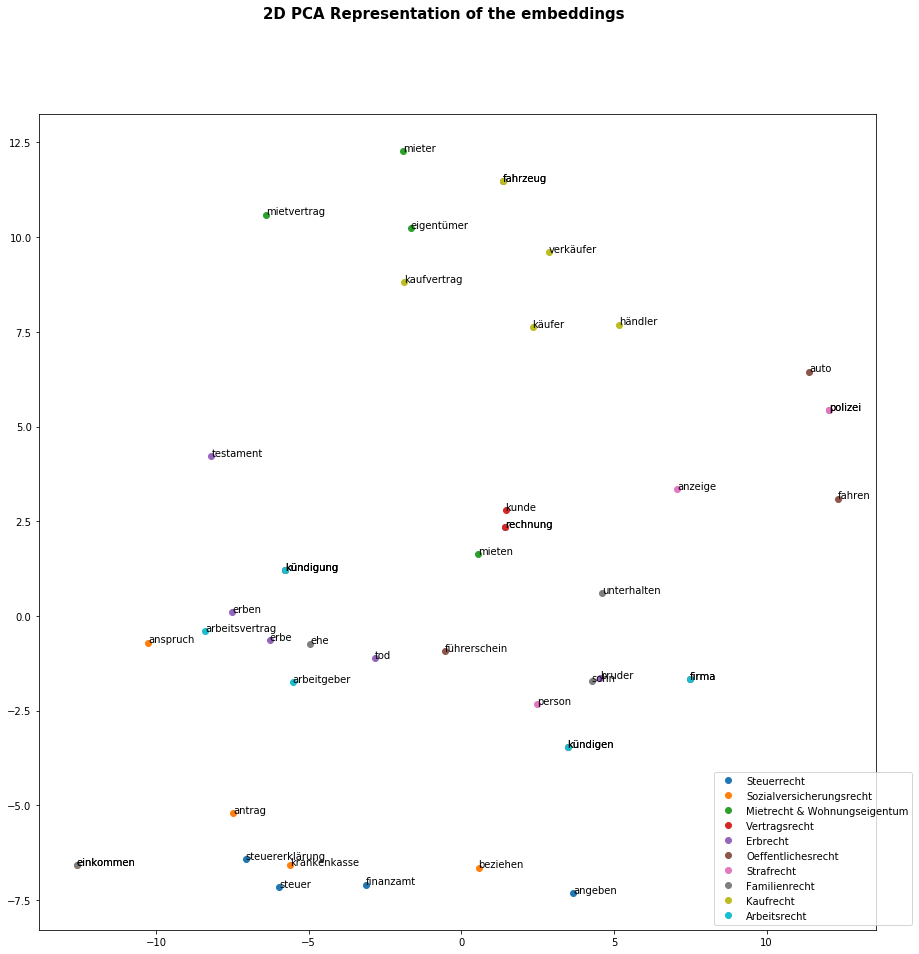

In [131]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
fig.suptitle('2D PCA Representation of the embeddings', fontsize = 15, weight = 'bold')
for j in range(len(most_common_plotVAL_)):
    ax.plot(most_common_plotVAL_[j][:,0],most_common_plotVAL_[j][:,1],'o')
    for i in range(len(most_common_plotVAL_[j])):
        #print(most_common_plot[4][i][0])
        label = most_common_plot[j][i][0]
        ax.annotate(label,(most_common_plotVAL_[j][i][0], most_common_plotVAL_[j][i][1]))
legend_data = ['Steuerrecht','Sozialversicherungsrecht','Mietrecht & Wohnungseigentum',
               'Vertragsrecht','Erbrecht','Oeffentlichesrecht','Strafrecht','Familienrecht',
               'Kaufrecht','Arbeitsrecht']
plt.legend(legend_data,loc=4,prop={'size':10}, bbox_to_anchor=(1.05,0))

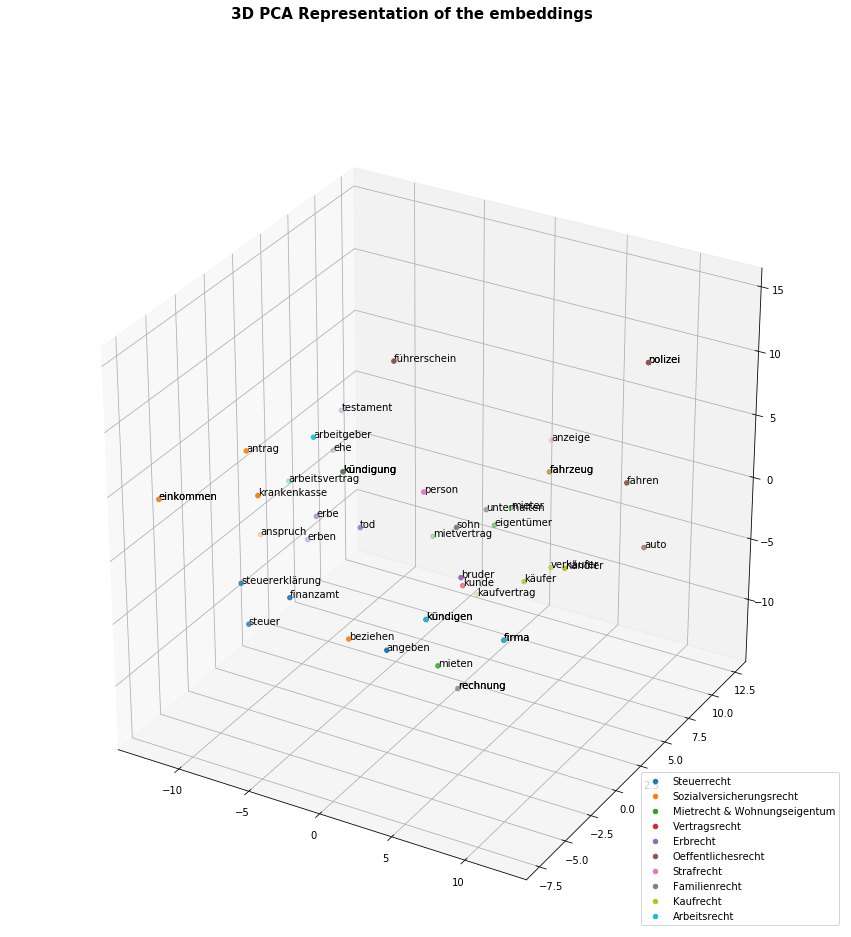

In [136]:
fig = plt.figure(figsize = (15,15))
ax = plt.axes(projection='3d')
fig.suptitle('3D PCA Representation of the embeddings', fontsize = 15, weight = 'bold')
for j in range(len(most_common_plotVAL_)):
    ax.scatter3D(most_common_plotVAL_[j][:,0],most_common_plotVAL_[j][:,1], most_common_plotVAL_[j][:,2], )
    for i in range(len(most_common_plotVAL_[j])):
        #print(most_common_plot[4][i][0])
        label = most_common_plot[j][i][0]
        ax.text(most_common_plotVAL_[j][i][0], most_common_plotVAL_[j][i][1], most_common_plotVAL_[j][i][2], label)
legend_data = ['Steuerrecht','Sozialversicherungsrecht','Mietrecht & Wohnungseigentum',
               'Vertragsrecht','Erbrecht','Oeffentlichesrecht','Strafrecht','Familienrecht',
               'Kaufrecht','Arbeitsrecht']
plt.legend(legend_data,loc=4,prop={'size':10})